# Exploracion de datos
### Que representa el dataset? - Informacion de las columnas


In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sweetviz
import seaborn
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
traffic_data = pandas.concat([data_2017, data_2018, data_2019])
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
...,...,...,...,...,...,...,...,...,...,...
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7


In [3]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560706 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   hora_inicio     int64 
 3   hora_fin        int64 
 4   dia             object
 5   estacion        object
 6   sentido         object
 7   tipo_vehiculo   object
 8   forma_pago      object
 9   cantidad_pasos  int64 
dtypes: int64(4), object(6)
memory usage: 298.8+ MB


In [4]:
traffic_data.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [5]:
traffic_data.tail()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7
812152,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,TELEPASE,7


### Conclusiones:

La tabla traffic_data representa un OLAP Cube cuyo fact es la cantidad de pasos, que significa el agregado de trafico vehicular dado cierta fecha, cierta hora, cierta estacion, cierto sentido, cierto vehiculo y cierta forma de pago. El origen de la tabla parece ser un peaje debido a que cuenta con una columna llamada forma de pago.

Despues de examinar los datos rapidamente podemos notar lo siguiente para cada una de las columnas:

1. Periodo: Representa el año de agregacion
2. Fecha: Representa la fecha de agregacion
3. Hora_inicio: Representa la hora de la agregacion
4. Hora_fin: Simplemente una hora adelante de la hora de inicio
5. Dia: Dia de la agregacion
6. Estacion: Estacion de la agregacion
7. Tipo_vehiculo: Tipo_vehiculo agregacion
8. Forma_pago: Forma de pago del peaje
9. Cantidad_de_pasos: Columna objetivo, es el total de vehiculos que pasaron por el peaje bajo ciertas condiciones.


# Analisis Exploratorio

                                             |      | [  0%]   00:00 -> (? left)


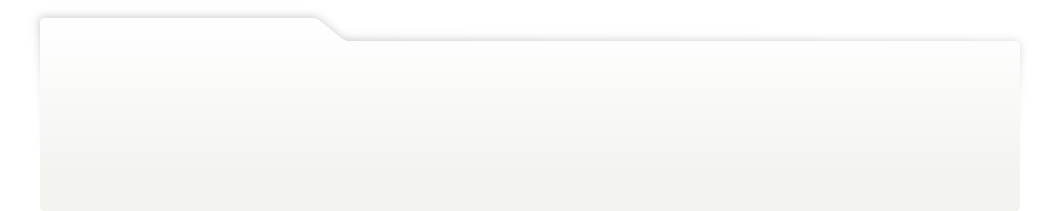
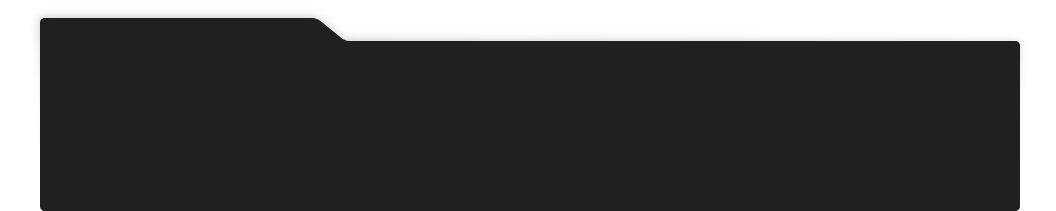
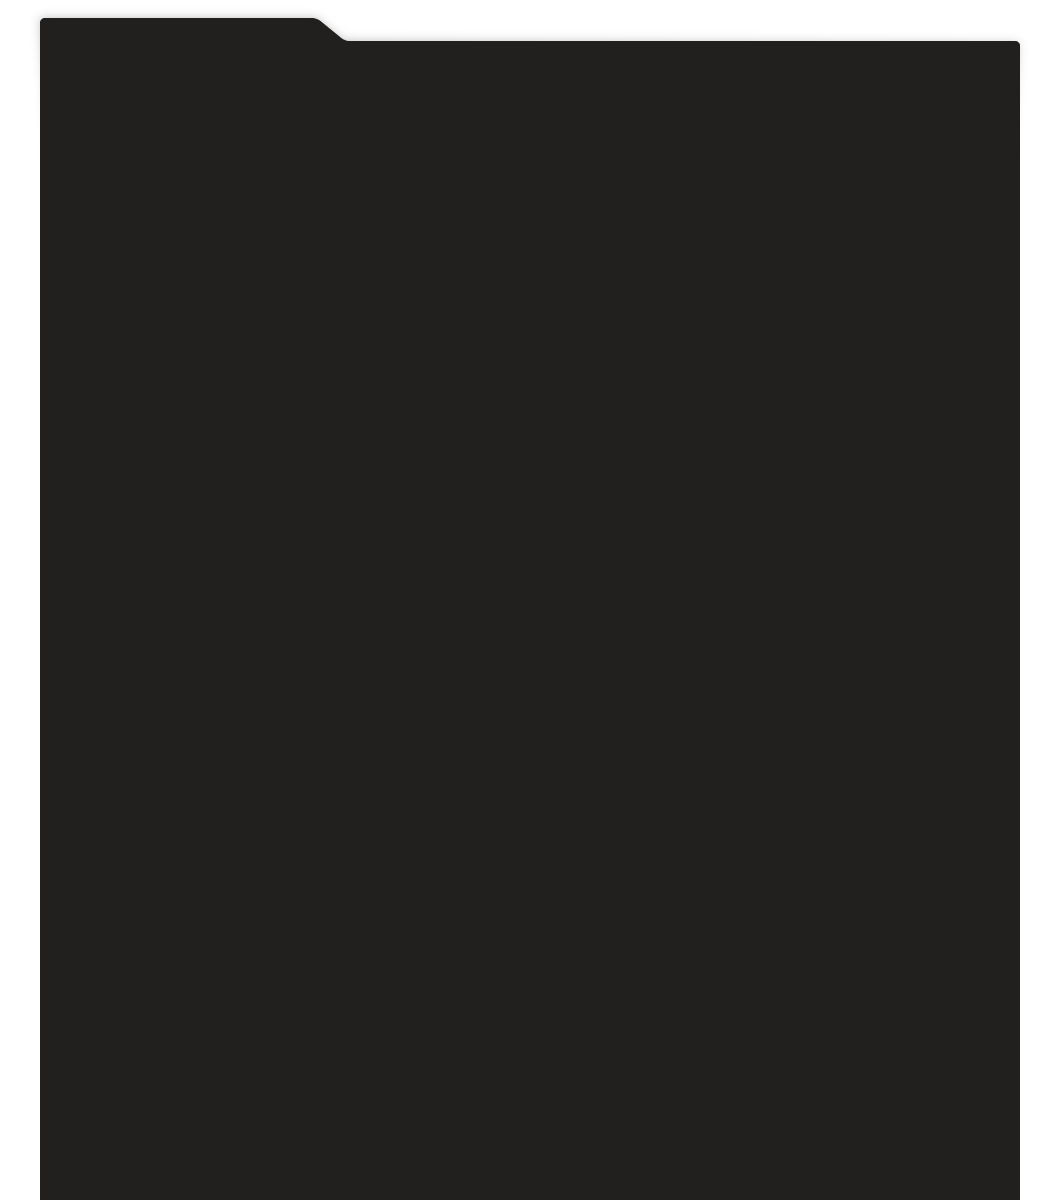
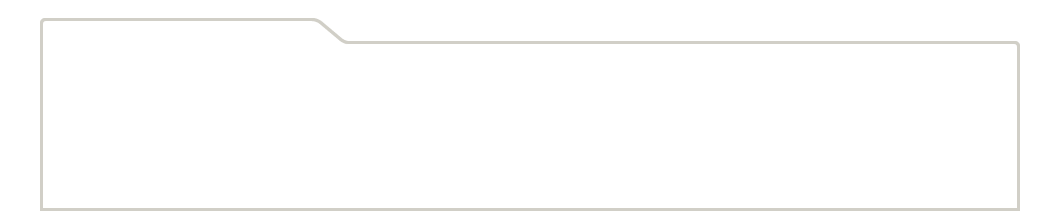
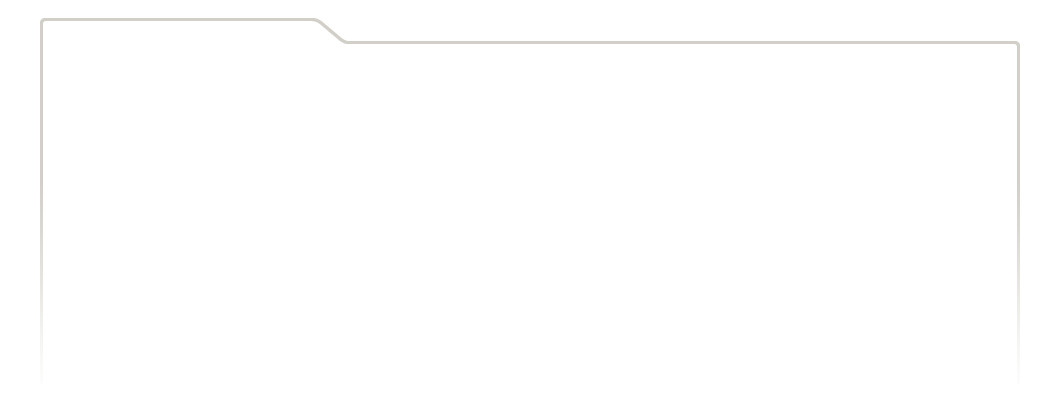
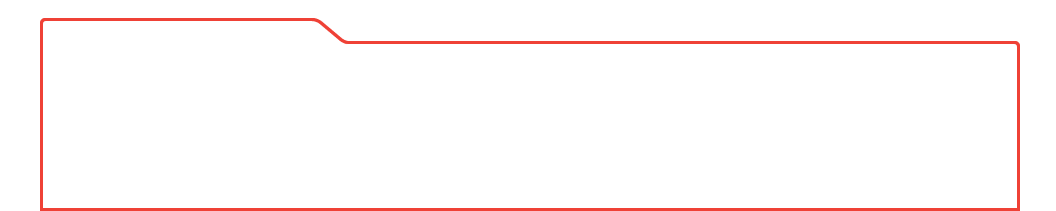
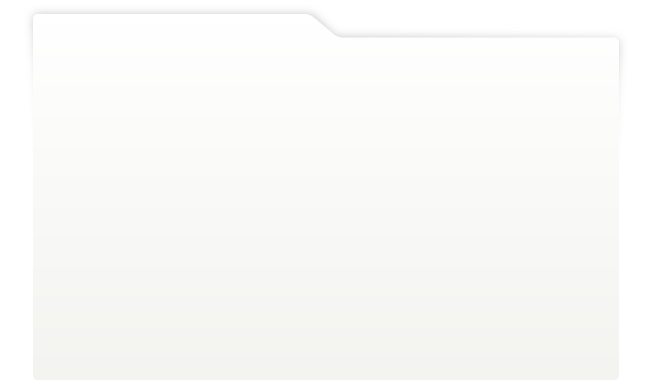
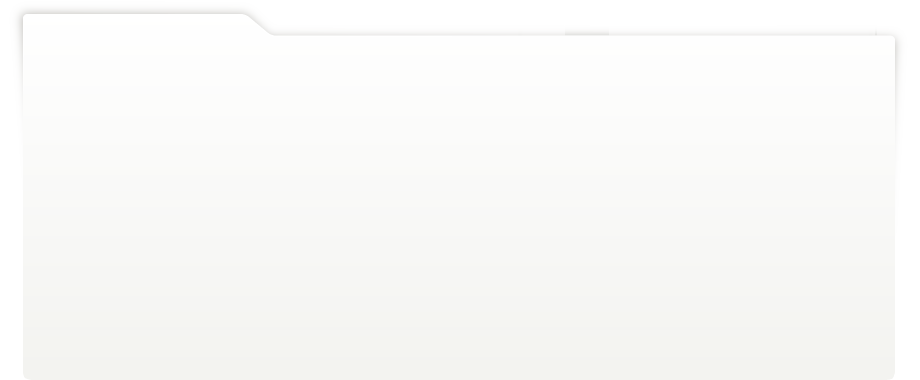
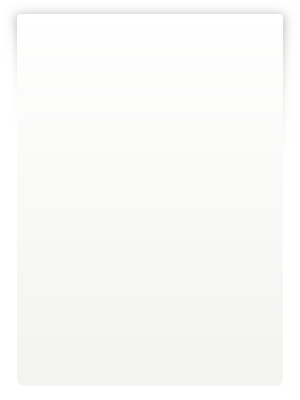
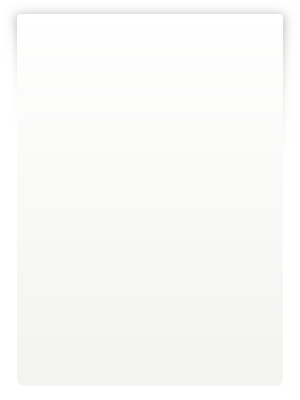
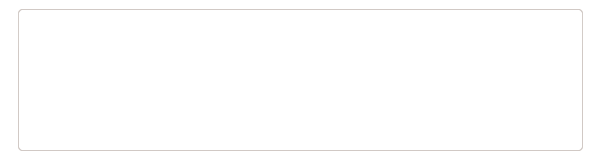
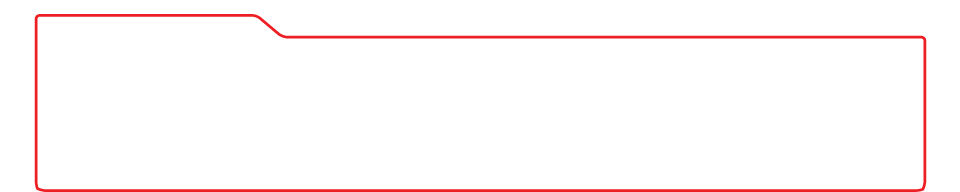
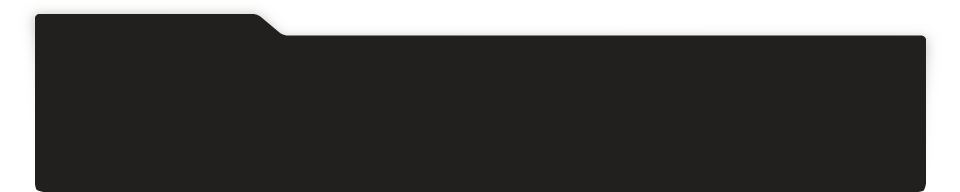
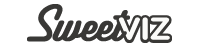
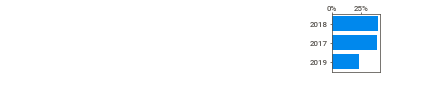
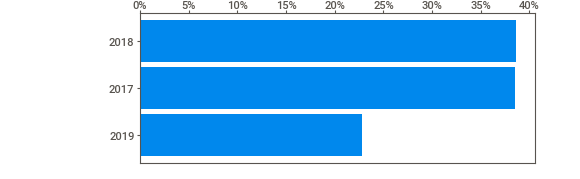
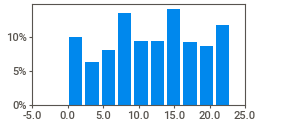
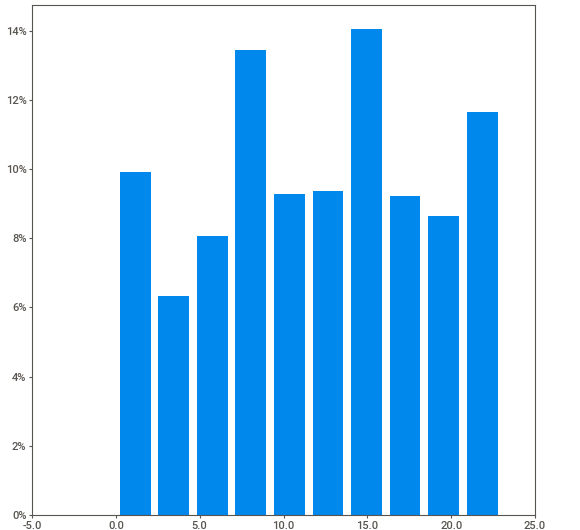
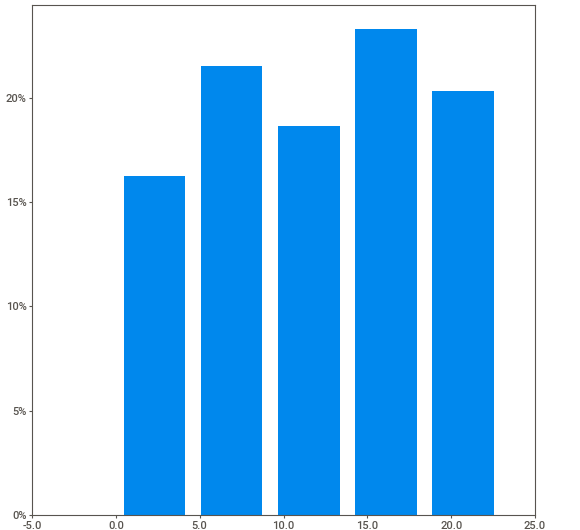
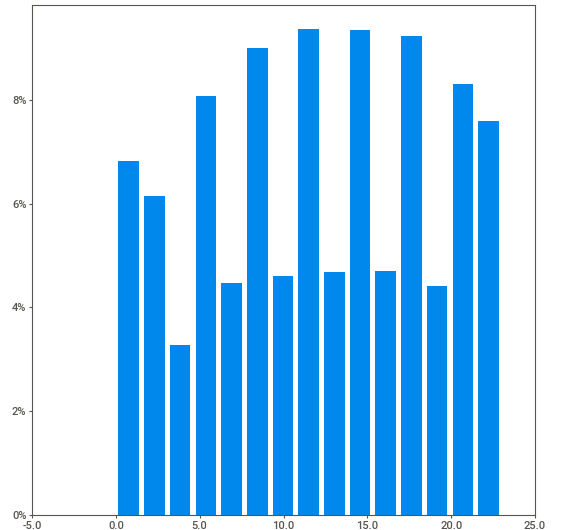
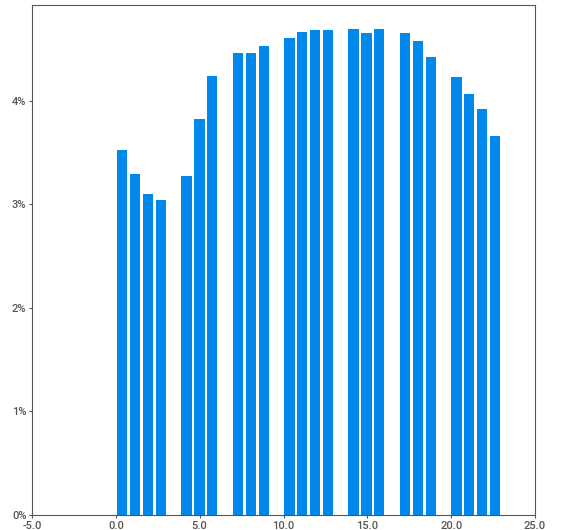
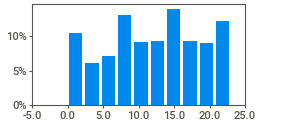
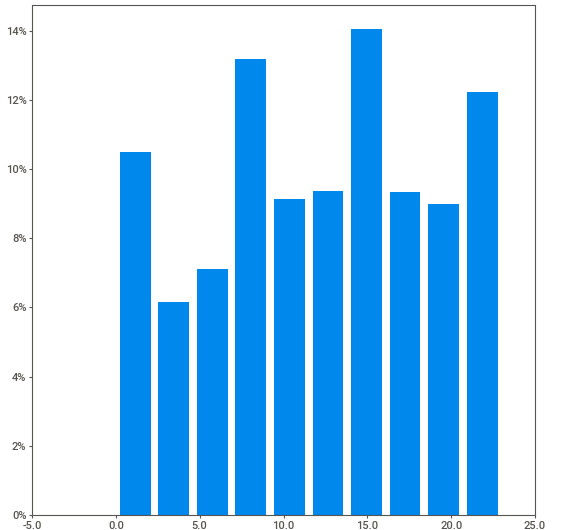
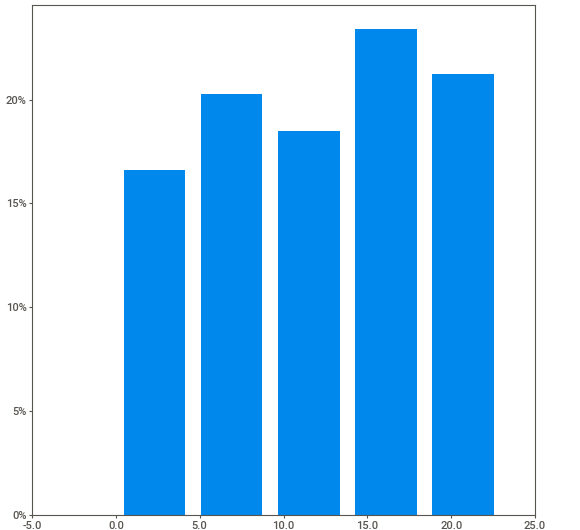
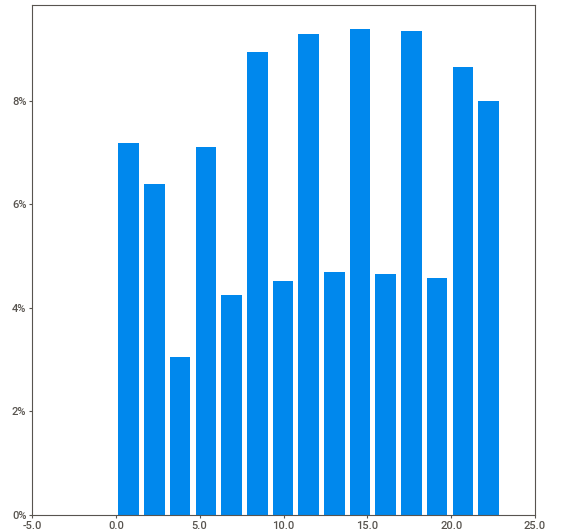
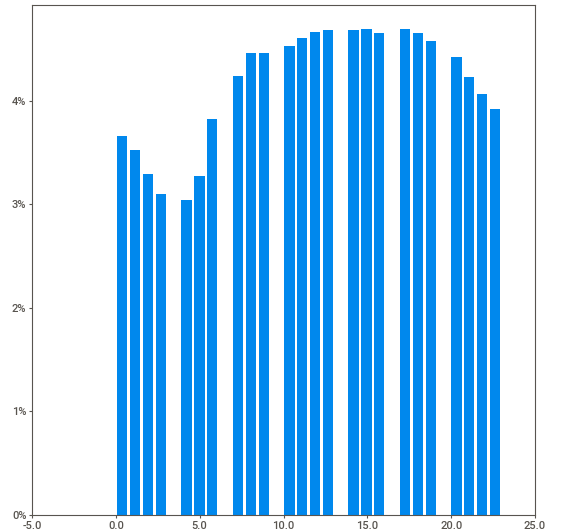
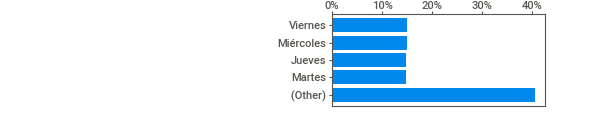
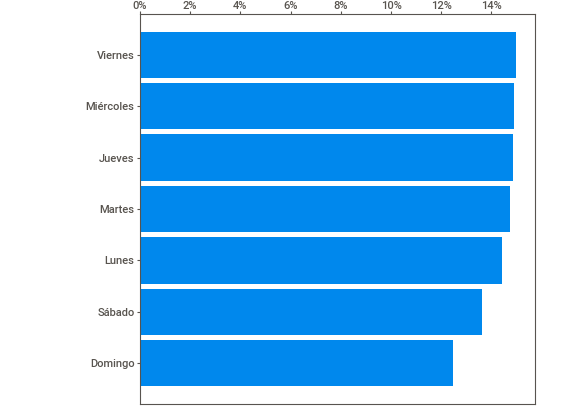
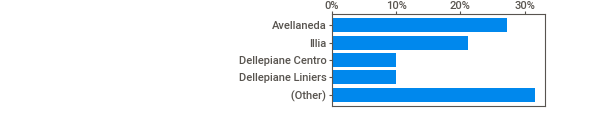
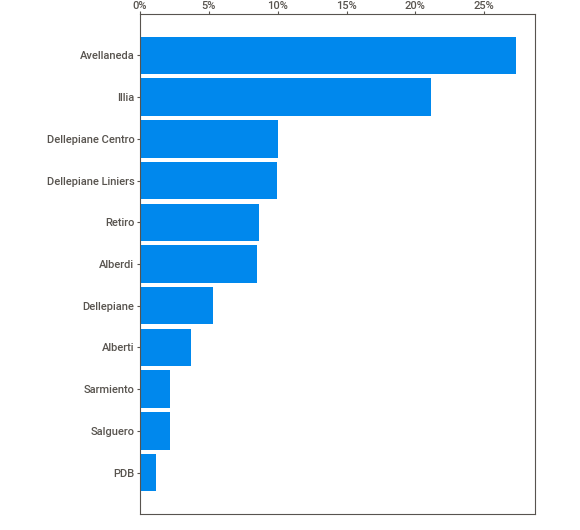
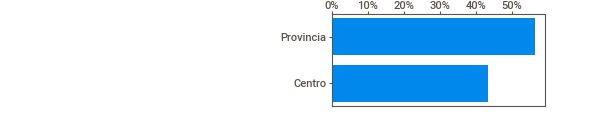
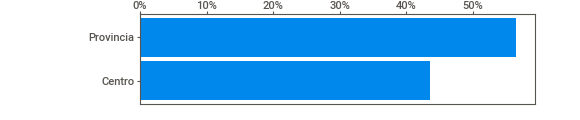
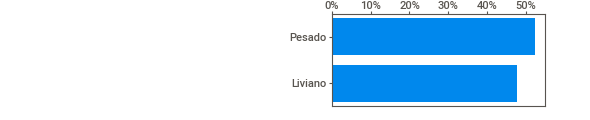
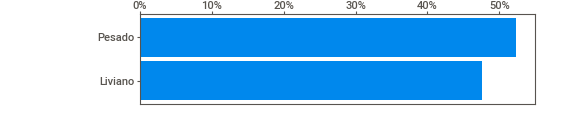
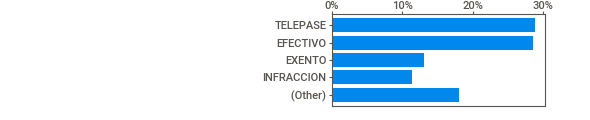
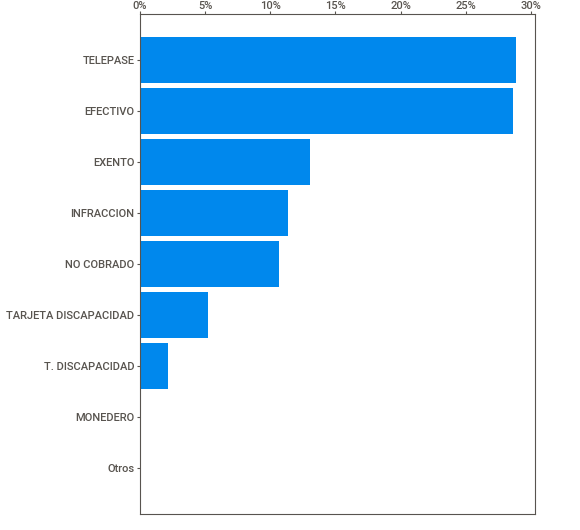
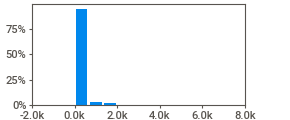
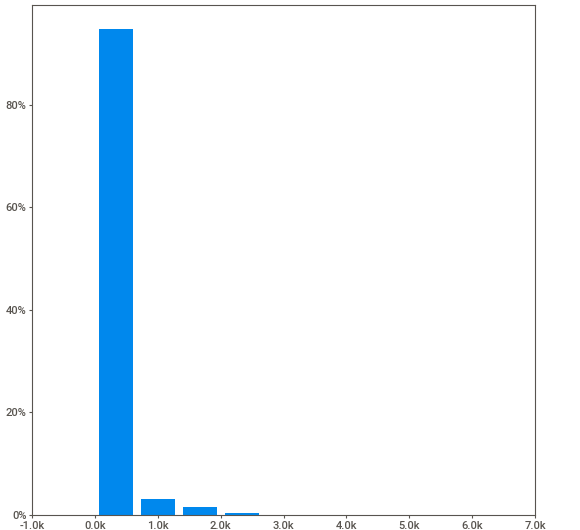
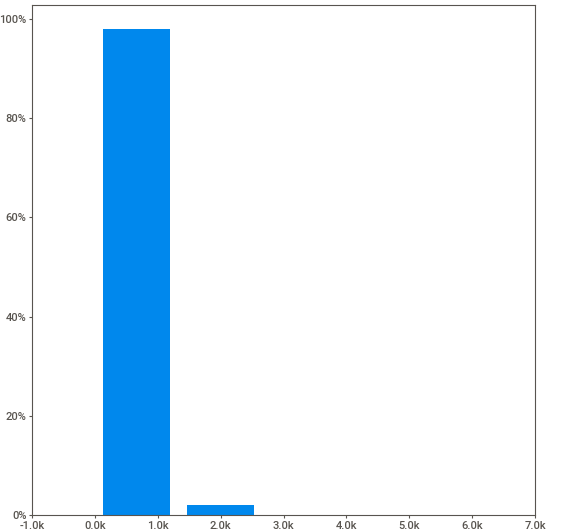
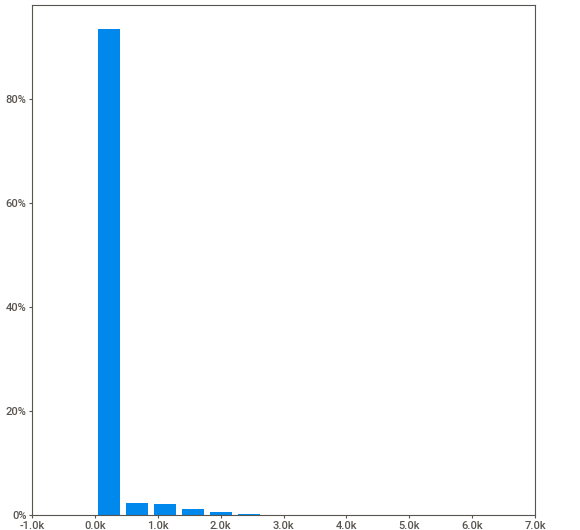
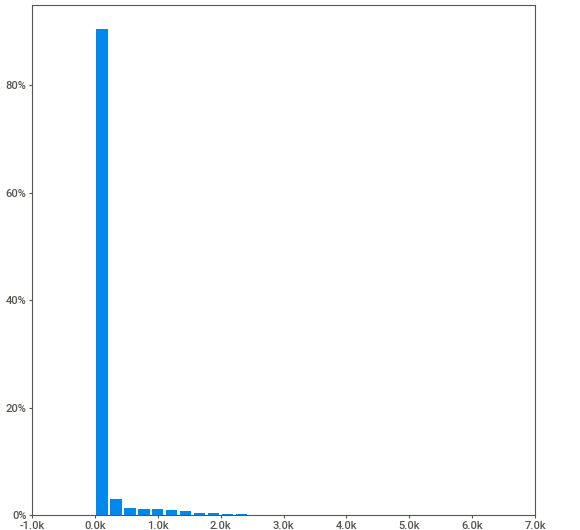
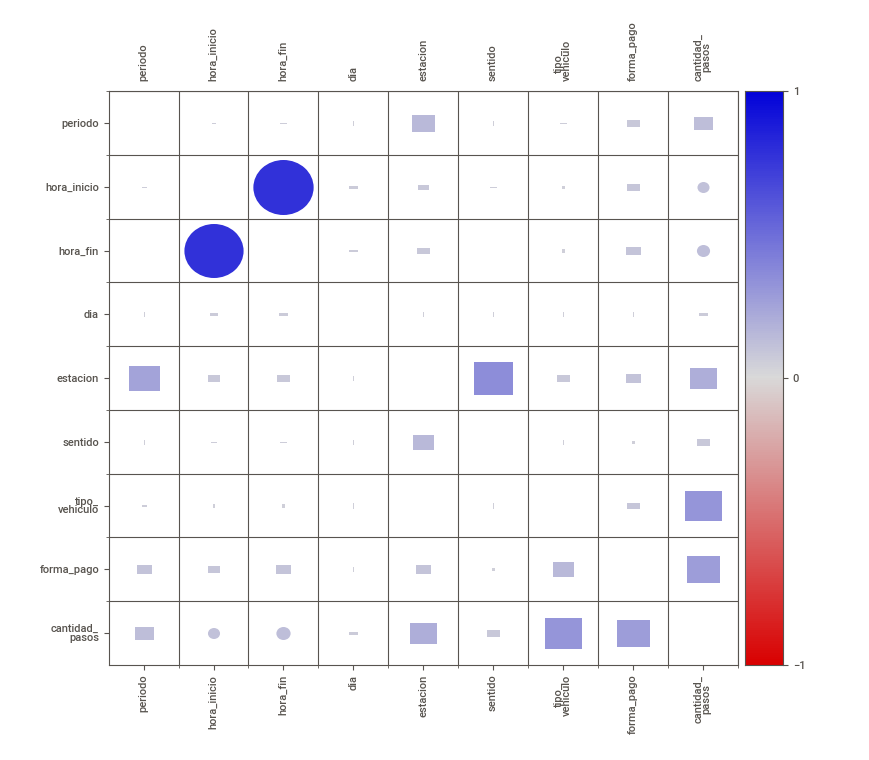
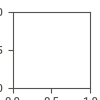

In [6]:
my_report = sweetviz.analyze(traffic_data)
my_report.show_notebook()

## Conclusiones:

- No tenemos datos nulos (Los datos tuvieron preprocesamiento), sin embargo se observa que hay fechas que no tienen registros.

- Sorpresivamente la hora de inicio no tiene una distrubucion uniforme (ciertas combinaciones no tuvieron pasos por la tanto probablemente esos registros no fueron calculados)

- La estacion con mayor cantidad de registros fue "Avellaneda"

- El sentido con mayor cantidad de registros fue "Provincia"

- En cuanto a la media y el promedio de "cantidad_de_pasos" nos damos cuenta que estan muy lejos, la mayoria de combinaciones tienen un bajo numero de pasos.

# Transformacion y Analisis de datos
Detalles del proyecto especifican trabajar unicamente con Estacion: "Ilia" y Pago: "Efectivo

In [7]:
traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
traffic_data = traffic_data[traffic_data['forma_pago'] == 'EFECTIVO']
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
1750,2017,2017-01-01,0,1,Domingo,Illia,Centro,Liviano,EFECTIVO,1
1755,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,10
1757,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,783
1761,2017,2017-01-01,1,2,Domingo,Illia,Centro,Pesado,EFECTIVO,3
1764,2017,2017-01-01,2,3,Domingo,Illia,Centro,Liviano,EFECTIVO,14
...,...,...,...,...,...,...,...,...,...,...
812010,2019,2019-12-31,21,22,Martes,Illia,Provincia,Liviano,EFECTIVO,556
812016,2019,2019-12-31,21,22,Martes,Illia,Provincia,Pesado,EFECTIVO,1
812080,2019,2019-12-31,22,23,Martes,Illia,Centro,Liviano,EFECTIVO,214
812085,2019,2019-12-31,22,23,Martes,Illia,Provincia,Liviano,EFECTIVO,190


In [8]:
traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha']) + pandas.to_timedelta(traffic_data['hora_inicio'], unit= 'hours')
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,traffic_timestamp
1750,2017,2017-01-01,0,1,Domingo,Illia,Centro,Liviano,EFECTIVO,1,2017-01-01 00:00:00
1755,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,10,2017-01-01 01:00:00
1757,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,783,2017-01-01 01:00:00
1761,2017,2017-01-01,1,2,Domingo,Illia,Centro,Pesado,EFECTIVO,3,2017-01-01 01:00:00
1764,2017,2017-01-01,2,3,Domingo,Illia,Centro,Liviano,EFECTIVO,14,2017-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...
812010,2019,2019-12-31,21,22,Martes,Illia,Provincia,Liviano,EFECTIVO,556,2019-12-31 21:00:00
812016,2019,2019-12-31,21,22,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-12-31 21:00:00
812080,2019,2019-12-31,22,23,Martes,Illia,Centro,Liviano,EFECTIVO,214,2019-12-31 22:00:00
812085,2019,2019-12-31,22,23,Martes,Illia,Provincia,Liviano,EFECTIVO,190,2019-12-31 22:00:00


In [9]:
traffic_data = traffic_data.groupby(['traffic_timestamp', 'tipo_vehiculo', 'sentido'])['cantidad_pasos'].sum().reset_index()

## Analisis General:
- Tipo de vehiculo
- Direccion de transito

<AxesSubplot:xlabel='traffic_timestamp'>

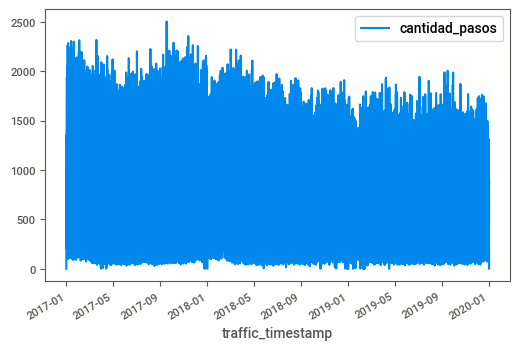

In [10]:
traffic_data[traffic_data['tipo_vehiculo'] == 'Liviano'].plot( 'traffic_timestamp', 'cantidad_pasos')

<AxesSubplot:xlabel='traffic_timestamp'>

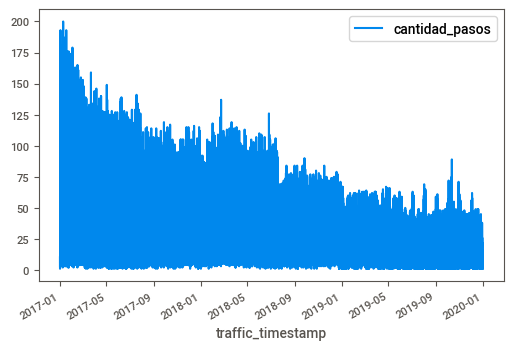

In [11]:
traffic_data[traffic_data['tipo_vehiculo'] == 'Pesado'].plot( 'traffic_timestamp', 'cantidad_pasos')

En cuanto a variacion de dependiendo del tipo de vehiculos podemos concluir que hay muchisimos mas vehiculos livianos y la cantidad de vehiculos pesado ha venido disminuyendo drasticamente.

<AxesSubplot:xlabel='tipo_vehiculo', ylabel='cantidad_pasos'>

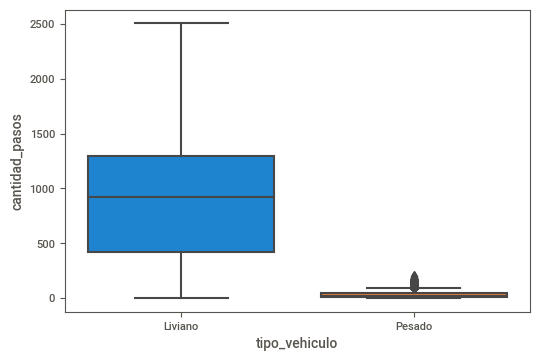

In [12]:
seaborn.boxplot(data=traffic_data, x='tipo_vehiculo', y='cantidad_pasos')

Esta comparacion resalta las diferencias entre la cantidad de pasos con base a cada uno de los tipos de vehiculos.

<AxesSubplot:xlabel='sentido', ylabel='cantidad_pasos'>

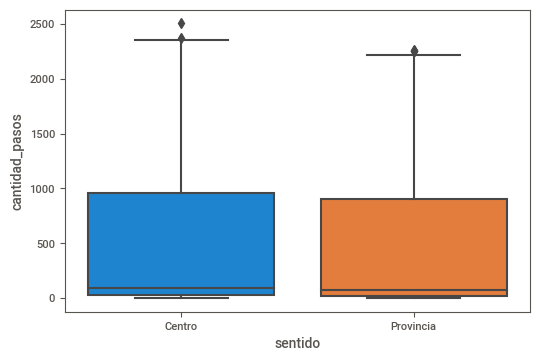

In [13]:
seaborn.boxplot(data=traffic_data, x='sentido', y='cantidad_pasos')

## Analisis de Serie de Tiempo:

La cantidad de vehiculos que van en direccion centro es levemente mayor que los que van hacia la provinvia

Hacemos transformacion de nuestros datos a series de tiempo.

In [14]:
data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
traffic_data = pandas.concat([data_2017, data_2018, data_2019])
traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
traffic_data = traffic_data[traffic_data['forma_pago'] == 'EFECTIVO']
traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha']) + pandas.to_timedelta(traffic_data['hora_inicio'], unit= 'hours')
traffic_data = traffic_data.groupby(['traffic_timestamp'])['cantidad_pasos'].sum()
traffic_data = pandas.DataFrame(traffic_data)
traffic_data

,cantidad_pasos
traffic_timestamp,
2017-01-01 00:00:00,1
2017-01-01 01:00:00,1374
2017-01-01 02:00:00,1734
2017-01-01 03:00:00,1247
2017-01-01 04:00:00,579
...,...
2019-12-31 19:00:00,1374
2019-12-31 20:00:00,1706
2019-12-31 21:00:00,1139


## Feature Engineering

Creamos nuestras dimensiones con base a series de tiempo, sacamos muchisimos atributos y los codificamos en su seno y coseno para aquellas dimensiones temporales periodicas.

In [15]:

def generate_timedata(X, has_hour = True):
    date_column = X.index.to_series()
    X['week'] = X.index.isocalendar().week
    X['day_week'] = X.index.isocalendar().day
    X['year'] = date_column.dt.year
    X['month'] = date_column.dt.month
    X['quarter'] = date_column.dt.quarter
    X['day_year'] = date_column.dt.dayofyear
    X['date'] = date_column.dt.date
    X['day'] = date_column.dt.day
    X['month_sin'] = numpy.sin(2*numpy.pi*X.month/12)
    X['month_cos'] = numpy.cos(2*numpy.pi*X.month/12)
    X['day_sin'] = numpy.sin(2*numpy.pi*X.day/30)
    X['day_cos'] = numpy.cos(2*numpy.pi*X.day/30)
    X['day_year_sin'] = numpy.sin(2*numpy.pi*X.day_year/365)
    X['day_year_cos'] = numpy.cos(2*numpy.pi*X.day_year/365)
    X['week_sin'] = numpy.sin(2*numpy.pi*X.week/52)
    X['week_cos'] = numpy.cos(2*numpy.pi*X.week/52)
    X['day_week_sin'] = numpy.sin(2*numpy.pi*X.day_week/7)
    X['day_week_cos'] = numpy.cos(2*numpy.pi*X.day_week/7)
    
    if has_hour is True:
        X['hour'] = date_column.dt.hour
    
    return X

In [16]:
generate_timedata(traffic_data)

,cantidad_pasos,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos,hour
traffic_timestamp,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,1,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0,0
2017-01-01 01:00:00,1374,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0,1
2017-01-01 02:00:00,1734,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0,2
2017-01-01 03:00:00,1247,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0,3
2017-01-01 04:00:00,579,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1374,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521,19
2019-12-31 20:00:00,1706,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521,20
2019-12-31 21:00:00,1139,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521,21


<AxesSubplot:xlabel='day_week', ylabel='cantidad_pasos'>

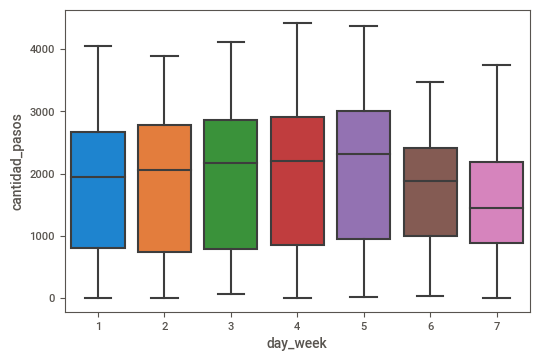

In [17]:
seaborn.boxplot(x = 'day_week', y = 'cantidad_pasos', data = traffic_data)

Notamos claramente que tenemos una mayor cantidad de pasos durante viernes y jueves, durante el domingo cae nuestro trafico.

<AxesSubplot:xlabel='week', ylabel='cantidad_pasos'>

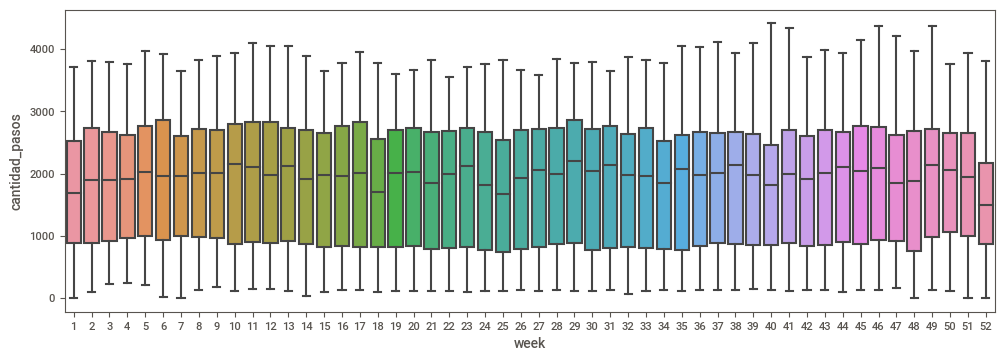

In [18]:
plt.figure(figsize=(12,4))
seaborn.boxplot(x = 'week', y = 'cantidad_pasos', data = traffic_data)

En cuanto a las semanas del año unicamente notamos una caida durante la primera y la ultima semana del año, hay otras en between donde tambien se observan caidas, pero nada extraordinario.

<AxesSubplot:xlabel='year', ylabel='cantidad_pasos'>

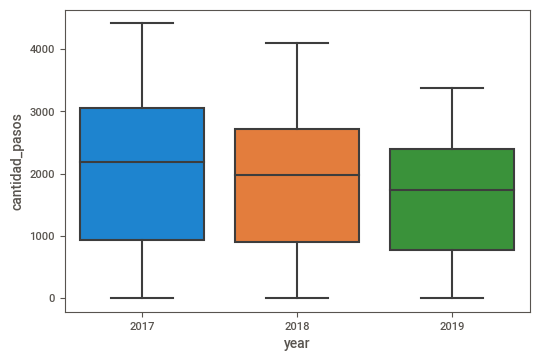

In [19]:
seaborn.boxplot(x = 'year', y = 'cantidad_pasos', data = traffic_data)

El mas importante de nuestros descubrimientos, vemos como cae el trafico a traves de los años, es algo bastante claro.

<AxesSubplot:xlabel='month', ylabel='cantidad_pasos'>

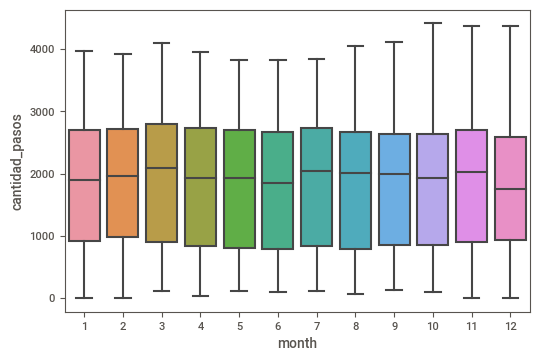

In [20]:
seaborn.boxplot(x = 'month', y = 'cantidad_pasos', data = traffic_data)

Tambien observamos cierta seasonalidad a traves de los meses, vemos como disminuye el trafico para los meses 5, 6 y 12.

<AxesSubplot:xlabel='month', ylabel='cantidad_pasos'>

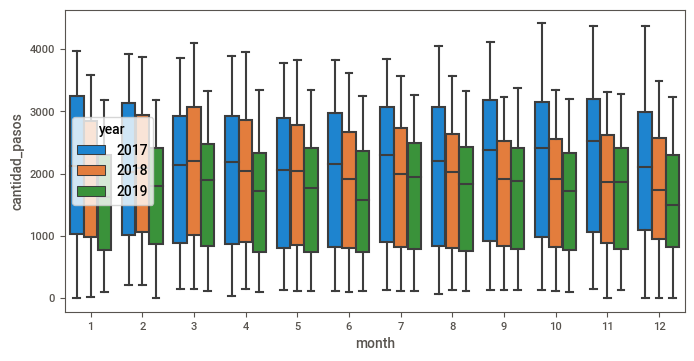

In [21]:
plt.figure(figsize=(8,4))
seaborn.boxplot(x = 'month', hue = 'year', y = 'cantidad_pasos', data = traffic_data)

Claramente observamos la influencia del año a traves de los meses.

<AxesSubplot:xlabel='day_week', ylabel='cantidad_pasos'>

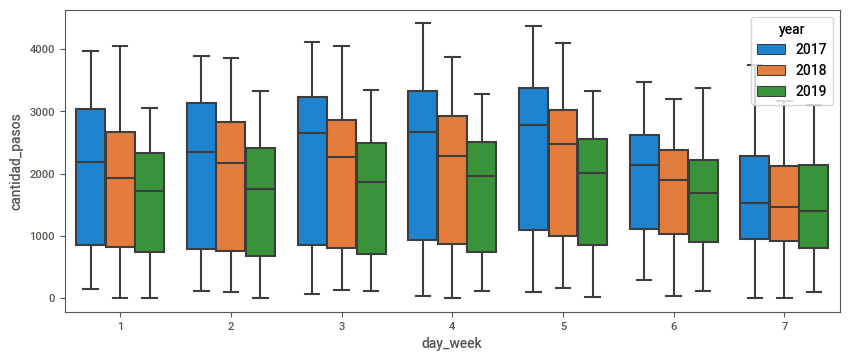

In [22]:
plt.figure(figsize=(10,4))
seaborn.boxplot(x = 'day_week', hue = 'year', y = 'cantidad_pasos', data = traffic_data)

Lo mismo pasa para los dias de la semana , el menos afectado es el domingo.

<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

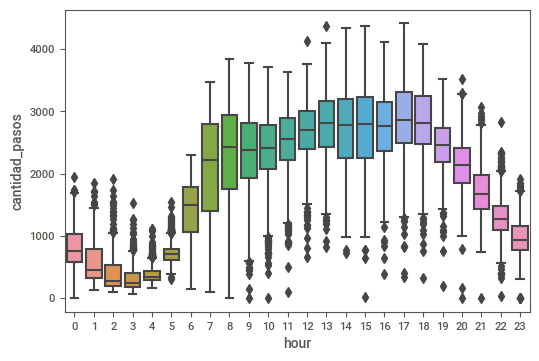

In [23]:
seaborn.boxplot(x = 'hour', y = 'cantidad_pasos', data = traffic_data)

Sin sorprendernos la hora es el factor que mas influye sobre el trafico de la estacion, donde tenemos horas valle y horas pico, se alinean bastante con las horas de mayor actividad humana.

<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

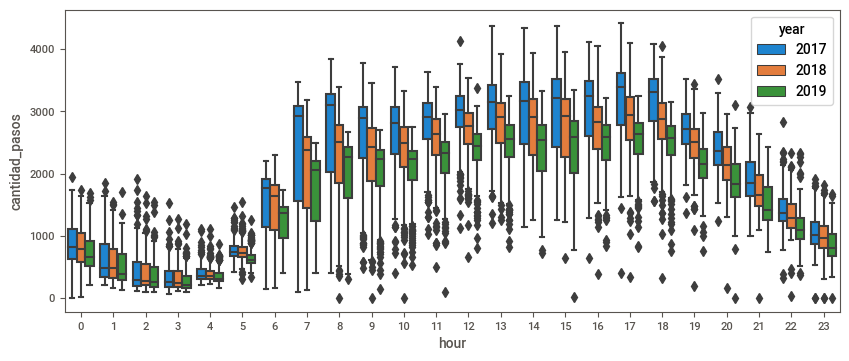

In [24]:
plt.figure(figsize=(10,4))
seaborn.boxplot(x = 'hour', y = 'cantidad_pasos', hue='year', data = traffic_data)

Vemos como disminuye la actividad diaria a traves de los años.

<AxesSubplot:xlabel='date'>

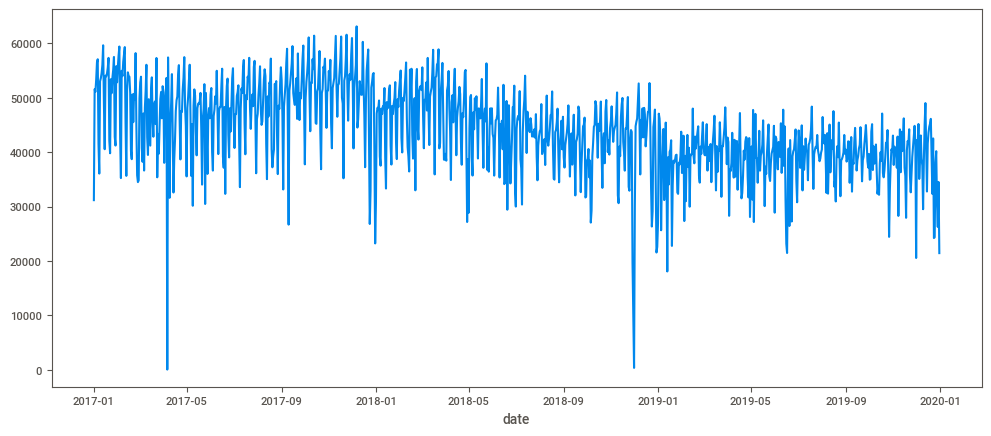

In [25]:
traffic_data.groupby('date')['cantidad_pasos'].sum().plot(x='date', y='cantidad_pasos', figsize=(12,5))

Nos damos cuenta que tenemos dos fechas sin datos, tambien vemos la periodicidad de nuestros datos principalmente semanales (picos en jueves y viernes, caidas en domingos). Tambien existe cierta periodicidad mensual pero no es tan significantiva.

<AxesSubplot:>

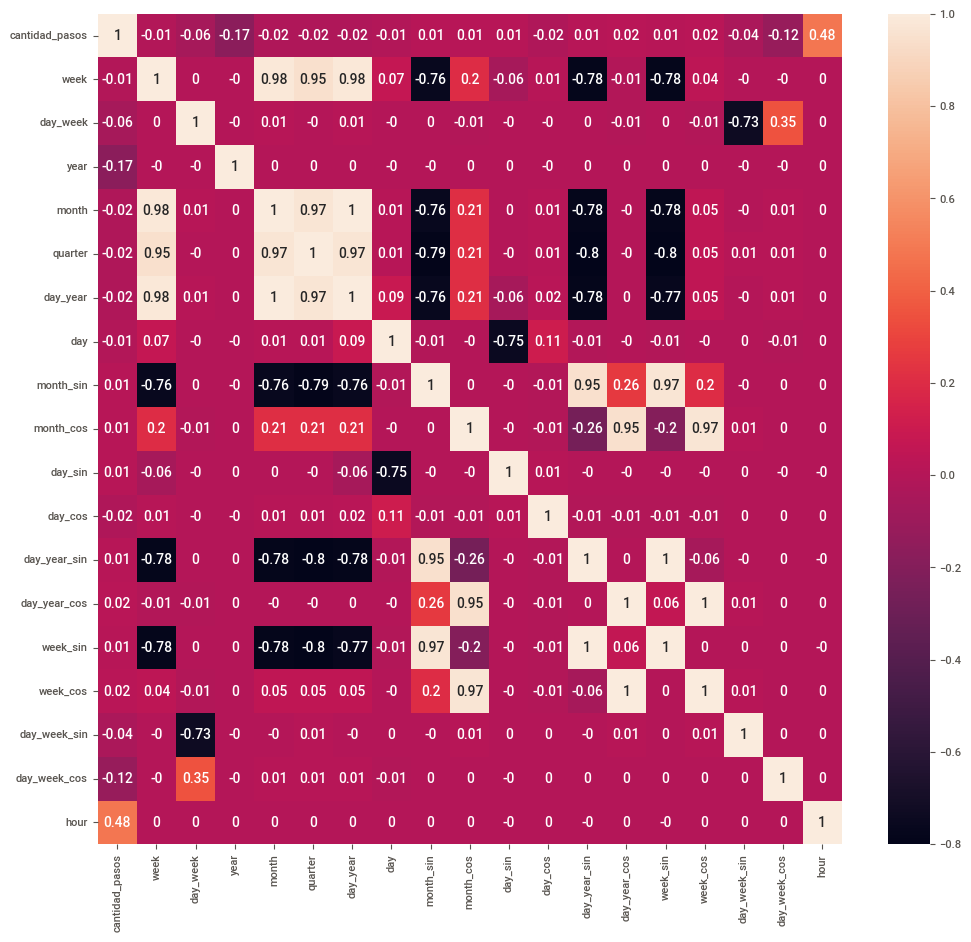

In [26]:
plt.figure(figsize=(12,11))
seaborn.heatmap(traffic_data.corr().round(2), cbar=True, annot=True)

Hacemos un mapa de calor para observar las correlaciones lineales de nuestras columnas de serie de tiempo. Como antes observamos nos damos que:
- La hora es la columna que mayor influencia tiene sobre el trafico (Caidas en la madrugada y en la noche, picos durante la tarde)
- El año es la segunda columna con mayor influencia sobre el trafico(en efectivo), notamos como disminuye con el avanzar de los años.
- La tercer columna con mayor influencia es el dia de la semana (Caidas durante el domingo, maximos durante el jueves y viernes)

## Modelo Predictivo

Modificamos nuestra funcion import data para que no sume la hora, vamos a hacer nuestras predicciones en bases diarias. Tambien llenamos nuestros campos faltantes con "backfill" el ultimo valor.

In [27]:
def import_data(forma_pago = ['EFECTIVO']):
    data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
    data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
    data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
    traffic_data = pandas.concat([data_2017, data_2018, data_2019])
    traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
    traffic_data = traffic_data[traffic_data['forma_pago'].isin(forma_pago)]
    traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha'])
    traffic_data = traffic_data.resample('D', on='traffic_timestamp').sum()['cantidad_pasos'].fillna('backfill')
    return traffic_data

traffic_data = import_data()
traffic_data


traffic_timestamp
2017-01-01    31183
2017-01-02    51568
2017-01-03    51093
2017-01-04    53332
2017-01-05    56486
              ...  
2019-12-27    40182
2019-12-28    30681
2019-12-29    26259
2019-12-30    34523
2019-12-31    21447
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: int64

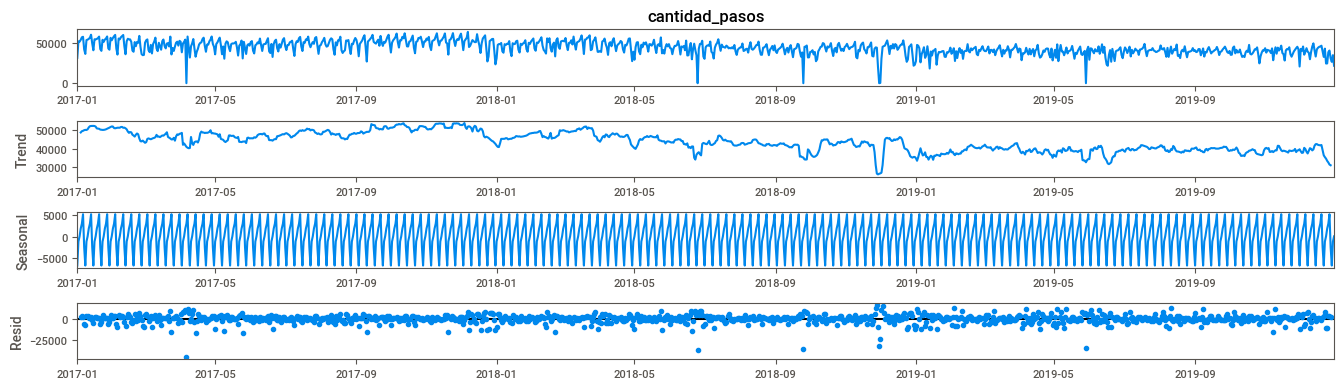

In [28]:
result = seasonal_decompose(traffic_data, model='additive')
fig = result.plot()
fig.set_figwidth(15)

Descomponiendo nuestra serie de tiempo en un modelo aditivo observamos que: hay clara seasonalidad semanal, el trend de la serie no es muy claro.

Alistamos nuestra data para el modelo: La separamos antes del ultimo cuarto de 2019, para que la data de train desconozca totalmente este ultimo periodo.
Elejimos como metrica comparativa MSE para darle un mayor peso a los errores que se encuentran bastante lejos del valor real (squared)

In [29]:
traffic_data = pandas.DataFrame(traffic_data)
daily_data = generate_timedata(traffic_data, has_hour = False)
daily_data

,cantidad_pasos,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,,,
2017-01-01,31183,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,2.079117e-01,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-02,51568,1,1,2017,1,1,2,2017-01-02,2,5.000000e-01,0.866025,4.067366e-01,0.913545,3.442161e-02,0.999407,0.120537,0.992709,0.781831,0.62349
2017-01-03,51093,1,2,2017,1,1,3,2017-01-03,3,5.000000e-01,0.866025,5.877853e-01,0.809017,5.161967e-02,0.998667,0.120537,0.992709,0.974928,-0.222521
2017-01-04,53332,1,3,2017,1,1,4,2017-01-04,4,5.000000e-01,0.866025,7.431448e-01,0.669131,6.880243e-02,0.997630,0.120537,0.992709,0.433884,-0.900969
2017-01-05,56486,1,4,2017,1,1,5,2017-01-05,5,5.000000e-01,0.866025,8.660254e-01,0.500000,8.596480e-02,0.996298,0.120537,0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,40182,52,5,2019,12,4,361,2019-12-27,27,-2.449294e-16,1.000000,-5.877853e-01,0.809017,-6.880243e-02,0.997630,0.0,1.0,-0.974928,-0.222521
2019-12-28,30681,52,6,2019,12,4,362,2019-12-28,28,-2.449294e-16,1.000000,-4.067366e-01,0.913545,-5.161967e-02,0.998667,0.0,1.0,-0.781831,0.62349
2019-12-29,26259,52,7,2019,12,4,363,2019-12-29,29,-2.449294e-16,1.000000,-2.079117e-01,0.978148,-3.442161e-02,0.999407,0.0,1.0,-0.0,1.0


In [30]:
daily_data['date'] = pandas.to_datetime(daily_data['date'])
train_data = daily_data[daily_data.index < datetime(2019, 10, 1)].copy()
test_data = daily_data[daily_data.index >= datetime(2019, 10, 1)].reset_index(drop=True).copy()

### Modelo Benchmark: Linear Regression
Escojemos como modelo benchmark a la regresion lineal

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [32]:
X_train = train_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_train = train_data['cantidad_pasos'].copy()
X_test = test_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_test = test_data['cantidad_pasos'].copy()

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test,y_pred)
lr_res = {'model': 'linear_regression', 'mse': round(mse_lr,1), 'mae': round(mae_lr,1), 'caract': 'Multivariate_linear_regression'}
lr_res

{'model': 'linear_regression',
 'mse': 25133656.3,
 'mae': 3798.8,
 'caract': 'Multivariate_linear_regression'}

In [35]:
results = pandas.DataFrame(lr_res, index = [0])
results

,model,mse,mae,caract
0,linear_regression,25133656.3,3798.8,Multivariate_linear_regression


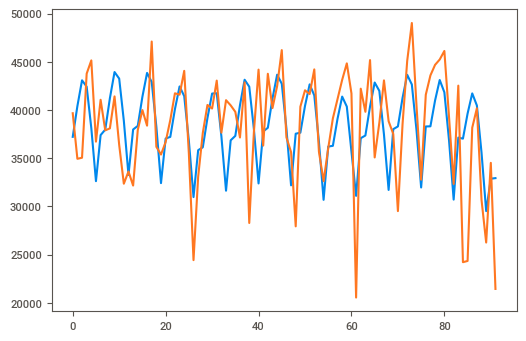

In [36]:
plt.plot(y_pred)
plt.plot(y_test)

Nuestro modelo performa bastante mejor de lo esperado, esta regresion lineal funciona bien por el feature engineering antes realizado. Para cada una de las predicciones podemos esperar un error absoluto de 3798. Parece seguir las tendencias semanales y un poco del trend dicembrino.

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [38]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_pred)
mae_rfr = mean_absolute_error(y_test,y_pred)
rfr_res = {'model': 'Random_forest', 'mse': round(mse_rfr,1), 'mae': round(mae_rfr,1), 'caract': 'Non_optimized Random forest'}
rfr_res

{'model': 'Random_forest',
 'mse': 22170418.1,
 'mae': 3369.0,
 'caract': 'Non_optimized Random forest'}

In [39]:
results.loc[len(results)] = rfr_res.values()

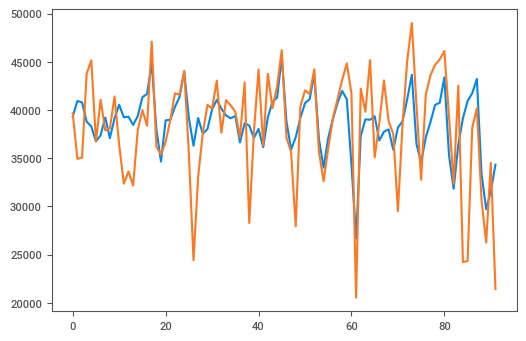

In [40]:
plt.plot(y_pred)
plt.plot(y_test)

In [59]:
rfr_opt = RandomForestRegressor()
params = {'max_depth': [x for x in range(1,125,5)],
         'max_features': ['auto','log2', None],
         'n_estimators': [x for x in range(10,150,5)]}

rfr_opt = RandomizedSearchCV(estimator = rfr_opt, param_distributions = params, n_iter = 100,
                                cv = 4, scoring = 'neg_mean_squared_error', random_state=42, n_jobs = -1)

rfr_opt.fit(X_train, y_train)
y_pred = rfr_opt.predict(X_test)
mse_rfr_opt = mean_squared_error(y_test, y_pred)
mae_rfr_opt = mean_absolute_error(y_test,y_pred)
rfr_res_opt = {'model': 'Random_forest', 'mse': round(mse_rfr_opt,1), 'mae': round(mae_rfr_opt,1), 'caract': 'Optimized Random forest'}
rfr_res_opt

{'model': 'Random_forest',
 'mse': 22997042.9,
 'mae': 3407.6,
 'caract': 'Optimized Random forest'}

In [43]:
results.loc[len(results)] = rfr_res_opt.values()
results

,model,mse,mae,caract
0,linear_regression,25133656.3,3798.8,Multivariate_linear_regression
1,Random_forest,22170418.1,3369.0,Non_optimized Random forest
2,Random_forest,23614229.7,3413.8,Optimized Random forest


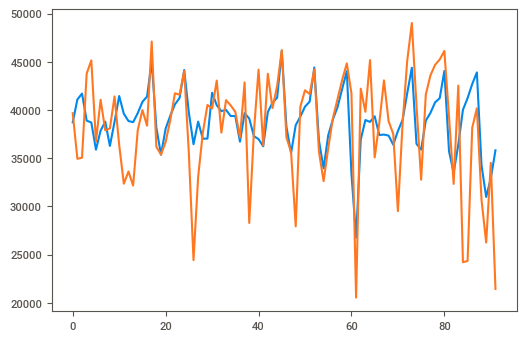

In [44]:
plt.plot(y_pred)
plt.plot(y_test)

In [45]:
train_prophet = pandas.DataFrame(y_train, index= X_train.index).reset_index()
train_prophet.columns = ['ds', 'y']
train_prophet

,ds,y
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486
...,...,...
998,2019-09-26,43110
999,2019-09-27,44985
1000,2019-09-28,41925
1001,2019-09-29,38348


In [46]:
prophet_model = Prophet(interval_width=0.8)
prophet_model.fit(train_prophet)
future_dates = prophet_model.make_future_dataframe(periods=92, freq='D')
future_dates.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.2003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1891.19   0.000426765       86.2386    3.49e-06       0.001      152  LS failed, Hessian reset 
      99       1891.26   0.000262479       54.6255      0.2107           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       1891.29   0.000126892       76.0508   2.137e-06       0.001      222  LS failed, Hessian reset 
     191        1891.5    0.00126033       73.1851   1.573e-05       0.001      371  LS failed, Hessian reset 
     199       1891.55   0.000109738       62.9752      0.5475      0.5475      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1891.68   7.05867e-08        62.717      0.2397           1      467   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [47]:
forecast = prophet_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1085,2019-12-22,32890.259240,25095.923662,40055.021087
1086,2019-12-23,38506.297053,31673.725358,46207.825798
1087,2019-12-24,39467.270020,31635.057514,46675.631066
1088,2019-12-25,41012.641630,33373.317223,48444.198496
1089,2019-12-26,41789.543408,34279.171633,49467.087267
1090,2019-12-27,43752.175759,36188.910758,50734.367853
1091,2019-12-28,35448.099228,28334.810685,42562.647514
1092,2019-12-29,30765.003326,23746.959194,38074.974015
1093,2019-12-30,36428.764066,28898.432491,43832.878646
1094,2019-12-31,37468.505586,29832.740107,44169.927688


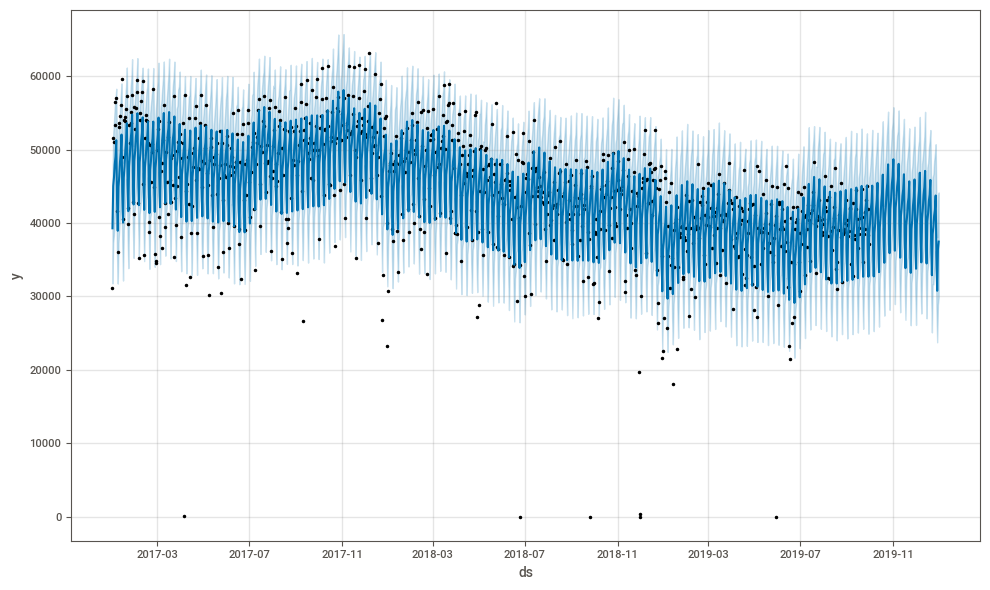

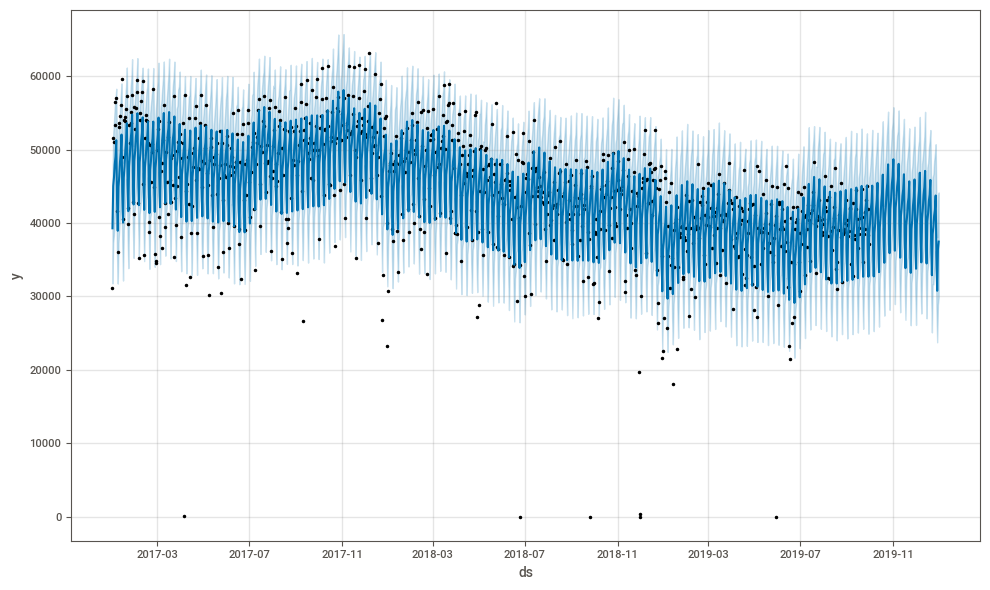

In [48]:
prophet_model.plot(forecast, uncertainty=True)

In [49]:
y_pred = forecast[forecast['ds'] >= datetime(2019,10,1)]['yhat']
y_pred.reset_index(drop=True, inplace=True)

In [50]:
mse_prophet = mean_squared_error(y_test, y_pred)
mae_prophet = mean_absolute_error(y_test,y_pred)
prophet_res = {'model': 'FbProphet', 'mse': round(mse_prophet,1), 'mae': round(mae_prophet,1), 'caract': 'Prophet model, without external predictors'}
prophet_res

{'model': 'FbProphet',
 'mse': 33884233.0,
 'mae': 4240.3,
 'caract': 'Prophet model, without external predictors'}

In [51]:
results.loc[len(results)] = prophet_res.values()

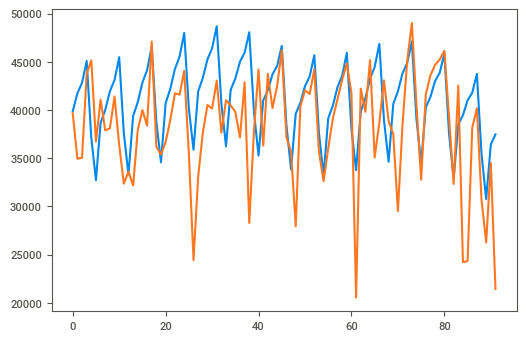

In [52]:
plt.plot(y_pred)
plt.plot(y_test)

In [53]:
results

,model,mse,mae,caract
0,linear_regression,25133656.3,3798.8,Multivariate_linear_regression
1,Random_forest,22170418.1,3369.0,Non_optimized Random forest
2,Random_forest,23614229.7,3413.8,Optimized Random forest
3,FbProphet,33884233.0,4240.3,"Prophet model, without external predictors"


El mejor modelo obtenido fue Random Forest sin RandomSearch, sin embargo esta muy cerano al modelo con RandomSearch. Probablemente los parametros iniciales eran lo sufcientemente buenos y el factor aleatorio en el otro modelo dio con un suboptimo local, cercano a los parametros iniciales.

<BarContainer object of 17 artists>

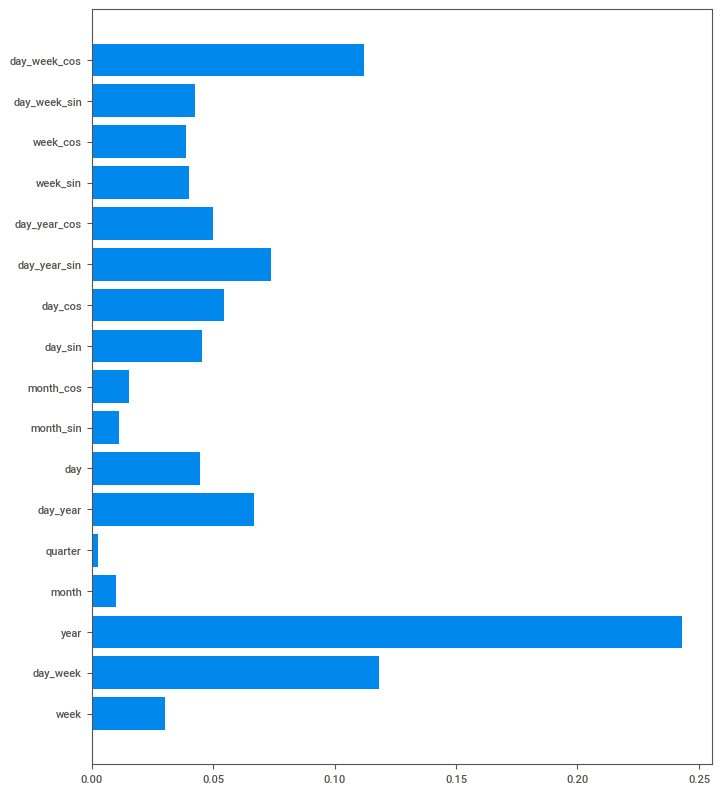

In [55]:
plt.figure(figsize=(8,10))
plt.barh(y = X_train.columns, width = rfr.feature_importances_)

Confirmamos nuestra hipotesis, incluso en el modelo RFR el año parece ser un buen predictor, junto con el coseno del dia de la semana y el seno del dia del año.

# Flujo de Trabajo y Pregunta

¿La caida de trafico observada en esta estacion, es unicamente para los pagos en efectivo? Analizar otros medios de pago, y evolucion de otros medios de pago.

1. Importar datos para los 4 metodos de pago con mas pasos, y tambien el total
2. Resamplear datos para cada una de los metodos de pago
3. Analizar la evolucion de los distintos metodos de pago y el total.
3. Predecir el total de flujo en la estacion

In [60]:
efectivo = import_data(['EFECTIVO'])
telepaso = import_data(['TELEPASE'])
exento = import_data(['EXENTO'])
infraccion = import_data(['INFRACCION'])
total = import_data(['EFECTIVO', 'TELEPASE', 'EXENTO', 'INFRACCION','NO COBRADO',
                     'TARJETA DISCAPACIDAD',  'T. DISCAPACIDAD', 'MONEDERO'])

<AxesSubplot:xlabel='traffic_timestamp'>

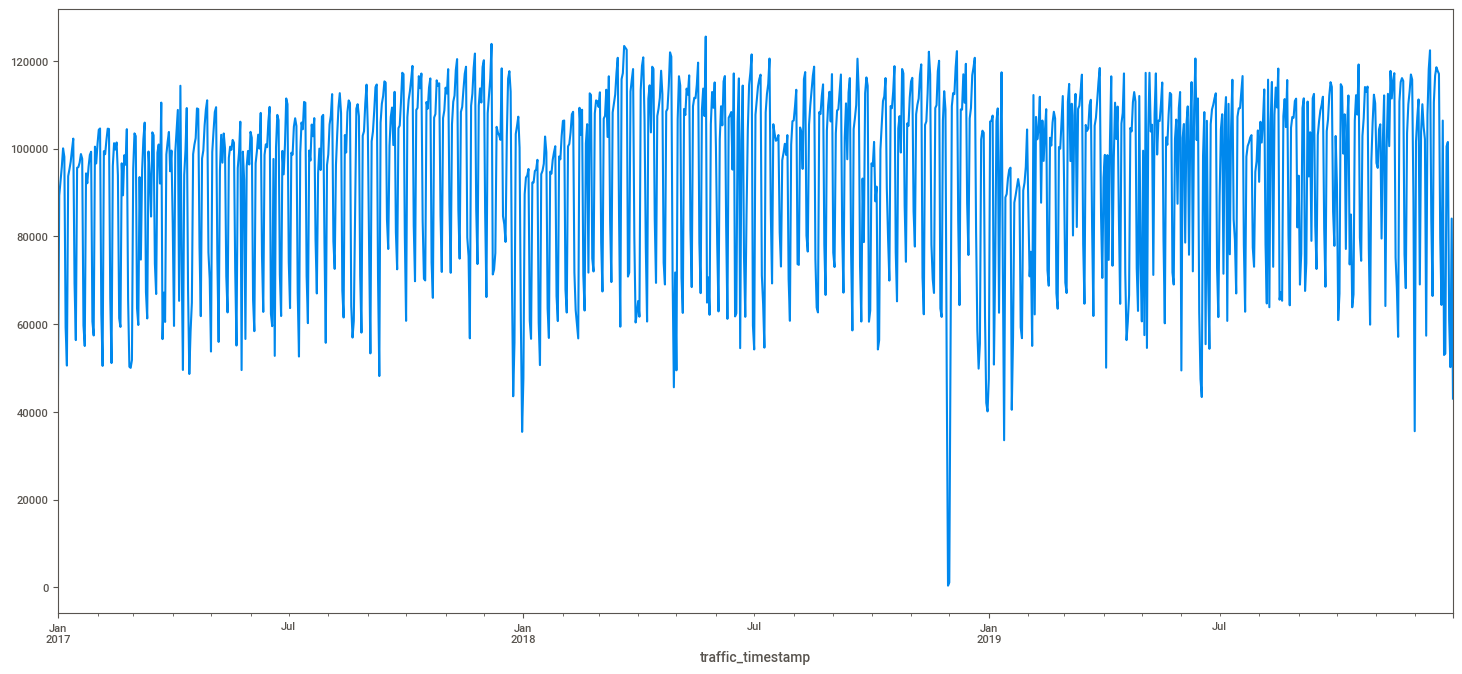

In [62]:
total.plot(figsize = (18,8))

El trafico total parece estar mas estable en el tiempo, al igual tiene sus periodiciades semanales, pero la tendencia anual parece inexistente. Al parecer es unicamnete el pago en efectivo que va a la baja.

In [61]:
cat_payment = pandas.concat([efectivo, telepaso, exento, infraccion], axis = 1)
cat_payment.columns = ['efectivo', 'telepaso', 'exento', 'infraccion']
cat_payment

,efectivo,telepaso,exento,infraccion
traffic_timestamp,,,,
2017-01-01,31183,12326,247,89
2017-01-02,51568,35621,626,179
2017-01-03,51093,39390,749,163
2017-01-04,53332,40294,698,163
2017-01-05,56486,41373,732,167
...,...,...,...,...
2019-12-27,40182,57035,441,657
2019-12-28,30681,28983,212,354
2019-12-29,26259,22577,164,331


In [63]:
cat_payment.describe()

,efectivo,telepaso,exento,infraccion
count,1095.000000,1095.000000,1095.000000,1095.000000
mean,43712.859361,46142.536986,586.778995,311.241096
std,8192.736927,15514.989022,238.244736,145.322494
min,0.000000,0.000000,0.000000,0.000000
25%,39061.500000,31793.500000,370.000000,211.000000
50%,43761.000000,49868.000000,621.000000,293.000000
75%,49498.000000,59688.500000,762.000000,398.000000
max,63127.000000,69329.000000,1315.000000,707.000000


<AxesSubplot:xlabel='traffic_timestamp'>

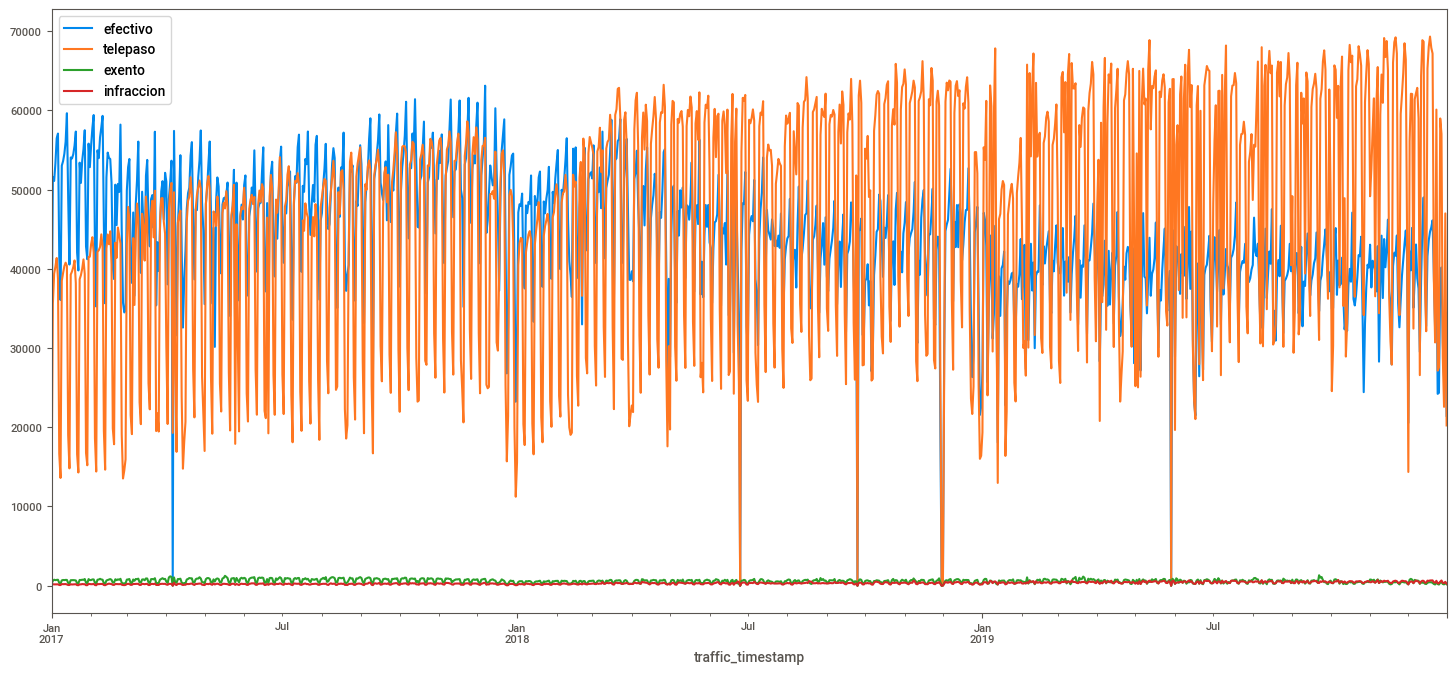

In [65]:
cat_payment.plot(figsize = (18,8))

Podemos notar que el telepaso tiene una gran variacion mucho mayor que el pagok en efectivo, sin embargo tienen medias similares, ol otros metodos de pago son poco prevalentes relativamente frente a estos.

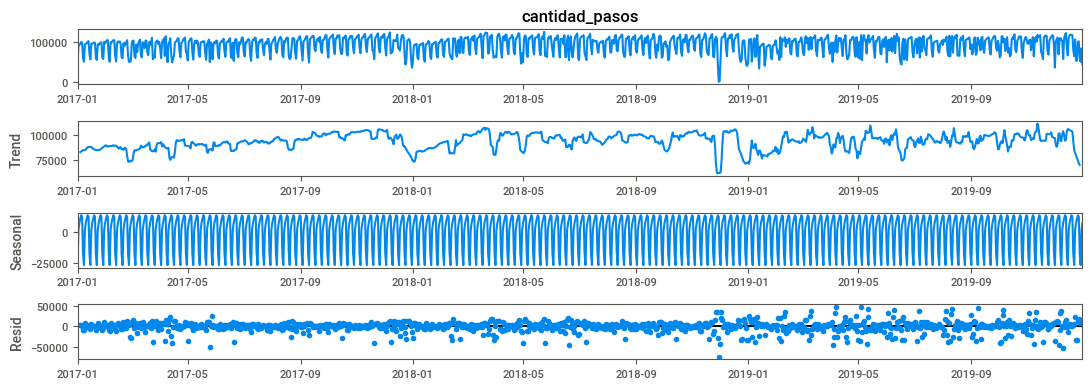

In [64]:
result = seasonal_decompose(total, model='additive')
fig = result.plot()
fig.set_figwidth(12)

La descomposicion de la serie total arroja un comportamiento similar a la serie en efectivo con la diferencia de tener un trend estable.

<AxesSubplot:xlabel='traffic_timestamp'>

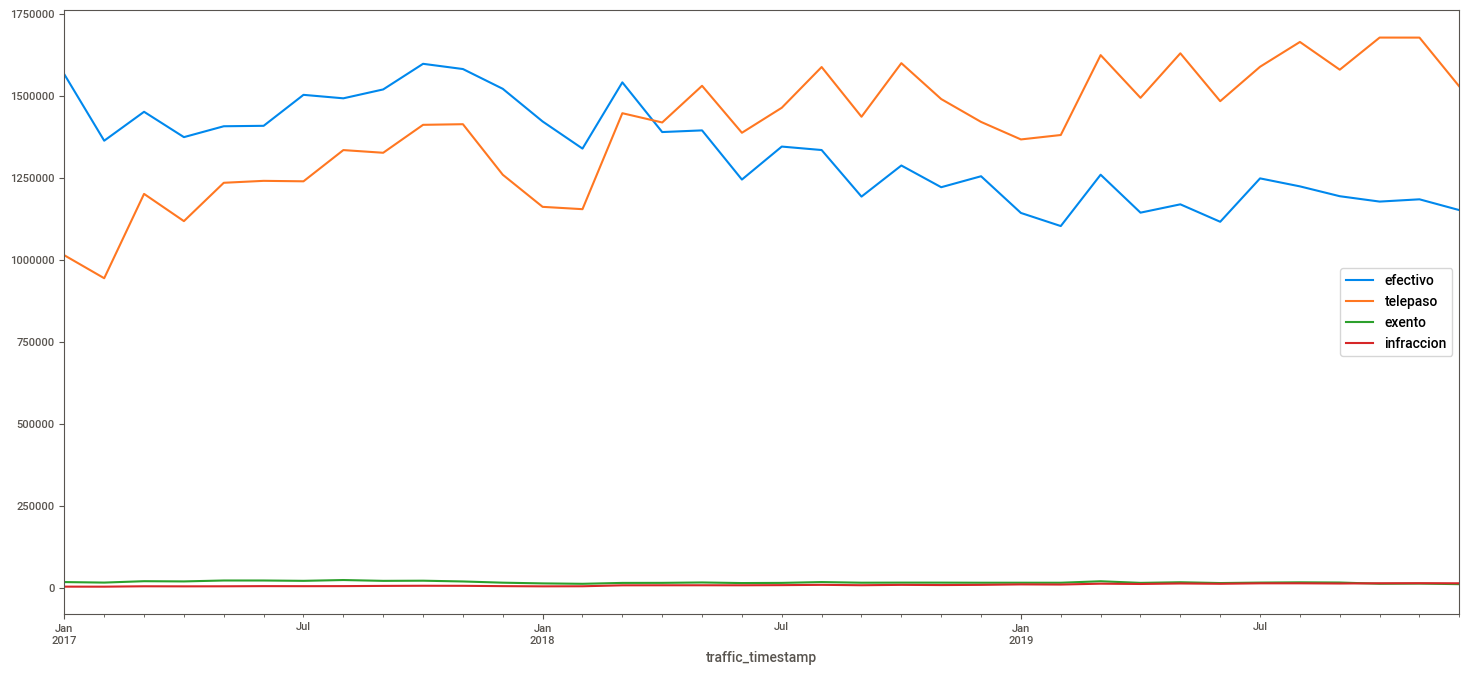

In [66]:
cat_monthly = cat_payment.resample('M').sum()
cat_monthly.plot(figsize = (18,8))

Agrupando nuestra serie a valores mensuales podemos darnos cuenta que mientras el pago en efectivo va perdiendo prevalencia, el pago con telepaso ve una adopcion creciente, es por esto que los niveles totales parecen ser estables.

<AxesSubplot:xlabel='traffic_timestamp'>

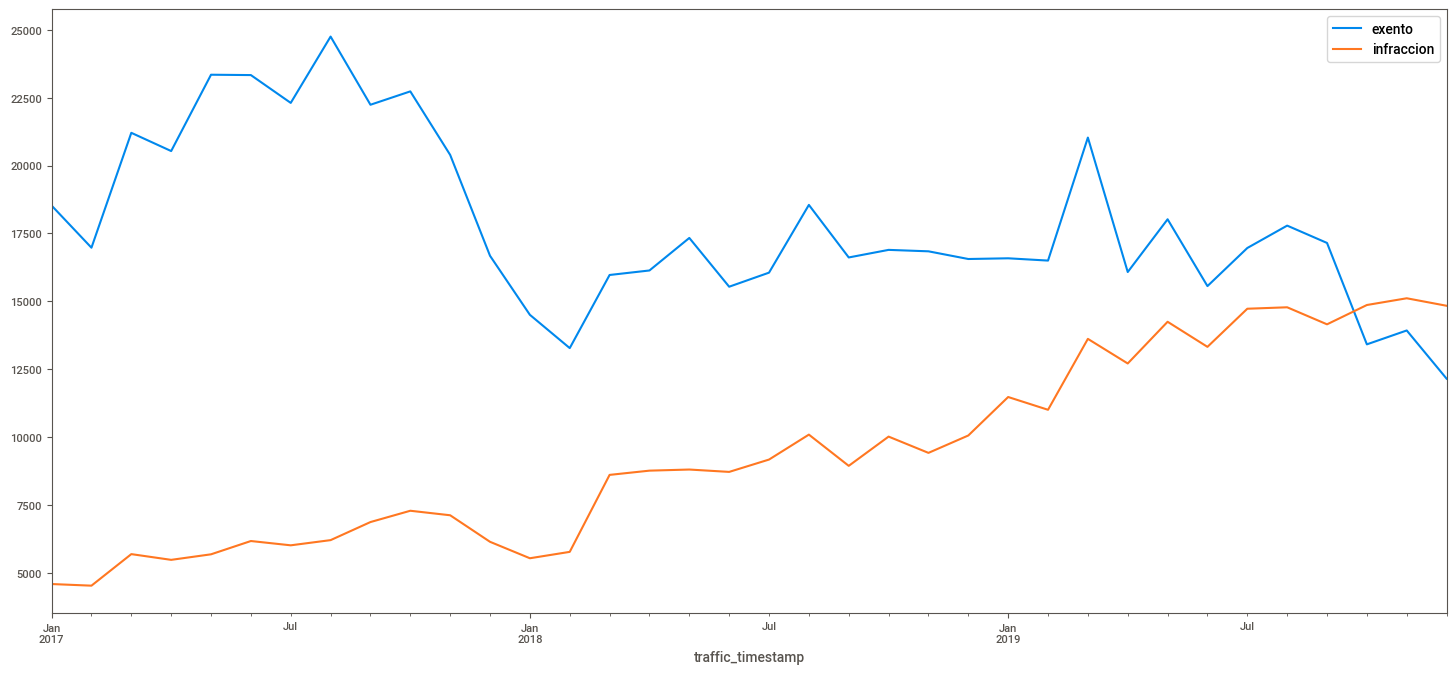

In [67]:
cat_monthly[['exento', 'infraccion']].plot(figsize = (18,8))

Podemos concluir que el numero de infraciones ha ido en aumento mientras que los exentos ha disminuido.

In [69]:
total = pandas.DataFrame(total)
total = generate_timedata(total, has_hour = False)
train_data = total[total.index < datetime(2019, 10, 1)].copy()
test_data = total[total.index >= datetime(2019, 10, 1)].reset_index(drop=True).copy()

In [70]:
X_train = train_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_train = train_data['cantidad_pasos'].copy()
X_test = test_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_test = test_data['cantidad_pasos'].copy()

In [71]:
train_data

,cantidad_pasos,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,,,
2017-01-01,45478,52,7,2017,1,1,1,2017-01-01,1,0.5,8.660254e-01,2.079117e-01,0.978148,0.017213,0.999852,0.0,1.0,-0.0,1.0
2017-01-02,89289,1,1,2017,1,1,2,2017-01-02,2,0.5,8.660254e-01,4.067366e-01,0.913545,0.034422,0.999407,0.120537,0.992709,0.781831,0.62349
2017-01-03,92602,1,2,2017,1,1,3,2017-01-03,3,0.5,8.660254e-01,5.877853e-01,0.809017,0.051620,0.998667,0.120537,0.992709,0.974928,-0.222521
2017-01-04,95813,1,3,2017,1,1,4,2017-01-04,4,0.5,8.660254e-01,7.431448e-01,0.669131,0.068802,0.997630,0.120537,0.992709,0.433884,-0.900969
2017-01-05,100044,1,4,2017,1,1,5,2017-01-05,5,0.5,8.660254e-01,8.660254e-01,0.500000,0.085965,0.996298,0.120537,0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,115132,39,4,2019,9,3,269,2019-09-26,26,-1.0,-1.836970e-16,-7.431448e-01,0.669131,-0.996659,-0.081676,-1.0,-0.0,-0.433884,-0.900969
2019-09-27,114052,39,5,2019,9,3,270,2019-09-27,27,-1.0,-1.836970e-16,-5.877853e-01,0.809017,-0.997917,-0.064508,-1.0,-0.0,-0.974928,-0.222521
2019-09-28,85619,39,6,2019,9,3,271,2019-09-28,28,-1.0,-1.836970e-16,-4.067366e-01,0.913545,-0.998880,-0.047321,-1.0,-0.0,-0.781831,0.62349


In [76]:
rfr_opt_2 = RandomForestRegressor()
params = {'max_depth': [x for x in range(1,30,1)],
         'max_features': ['auto','log2', None],
         'n_estimators': [x for x in range(25,125,10)]}

rfr_opt_2 = RandomizedSearchCV(estimator = rfr_opt_2, param_distributions = params, n_iter = 50,
                                cv = 4, scoring = 'neg_mean_squared_error', random_state=42, n_jobs = -1)

rfr_opt_2.fit(X_train, y_train)
y_pred = rfr_opt_2.predict(X_test)
mean_squared_error(y_test, y_pred)

326483258.36903906

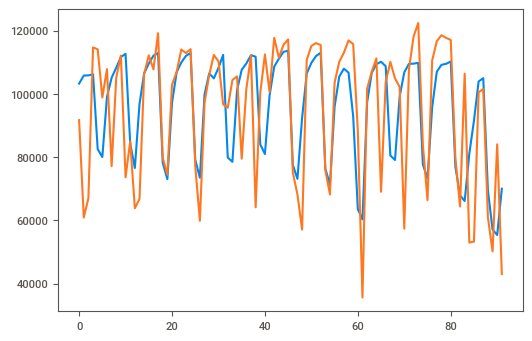

In [77]:
plt.plot(y_pred)
plt.plot(y_test)

El modelo parece predecir bien las caidas que siempre ocurren los domingos, tiene problemas prediciendo fechas con caracteristicas que no son recurrentes (festivos - eventos), una lista de festivos en Argentina durante el periodo podria ayudar con la prediccion 

In [78]:
mean_absolute_error(y_test,y_pred)

12403.485462396999